# Time Expressions in Genesis—Kings ("SBH")

In this notebook I aim to provide a simple overview of time expressions in the selected corpus of Genesis—Kings, the so-called Standard Biblical Hebrew texts (1). The ETCBC Hebrew database has a feature of `function` stored on phrases in the corpus. The primary function of interest here is `Time`. Thus, we begin with a basic exploratory overview of the ETCBC `Time` phrases, looking specifically at their identity and distribution.

*(1) The term 'Standard Biblical Hebrew' and the decision to limit the corpus is done only to give a firm starting point from which to analyze BH time phrases in the rest of the Hebrew Bible. It is thus not a stance on the ongoing debate about diachronic methods in Biblical Hebrew linguistics.*

In [20]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

# stats & data-containers
import collections
import pandas as pd
import numpy as np
import scipy.stats as stats

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
# prep the data
name = 'time_expressions'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads typ phono lex_utf8
''' 

# TF load statements
TF = Fabric(locations=hebrew_data, silent=True)
api = TF.load(load_features)
B = Bhsa(api=api, hoist=globals(), silent=True, name=name) # Bhsa functions for search and visualizing text

  0.00s loading features ...
   |     0.15s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.18s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     0.66s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.19s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
  5.83s All features loaded/computed - for details use loadLog()


In [3]:
'''
Here are a set of counting and plotting functions
for easy searching and visualizing.
'''

def count_df(results, index, feature):
    '''
    Counts features of a search result list.
    Returns a dataframe with sorted counts.
    index = n of result; feature = feature string to call on n
    '''
    count = collections.Counter(Fs(feature).v(res[index]) for res in results)
    count_df = pd.DataFrame.from_dict(count, orient='index', columns=['count'])
    return count_df.sort_values(ascending=False, by='count')

def barplot_counts(count_df, title='', reverse_labels=False, size=(8, 6)):
    '''
    Makes simple barplot of sorted feature counts.
    '''
    n_bars = list(range(0, count_df.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in count_df.index] if reverse_labels else count_df.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, count_df['count'].sort_values(ascending=False), palette='pastel')
    plt.xticks(n_bars, x_labels, size=18)
    plt.yticks(size=18)
    plt.title(title, size=18)
    plt.ylabel('count', size=18)
    plt.show()

In [4]:
# prepare the corpus

corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
print('Corpus:\n')
print('\n'.join(T.sectionFromNode(book)[0] for book in corpus))

Corpus:

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings
2_Kings


## Introductory Data Exploration

The `Time` feature is stored on phrases. What phrase types occur with these phrases, and in what quantity?

Number of time phrases in the corpus:
  0.29s 2180 results


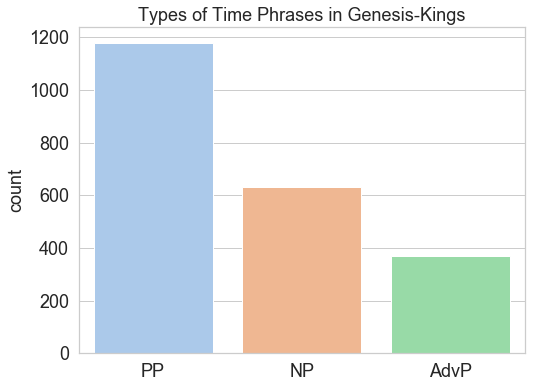


Phrase types and their frequency:


,count
PP,1180
NP,632
AdvP,368


In [5]:
find_time = '''
corpus
    phrase function=Time 
'''

# run the search, count features, and print/plot them
print('Number of time phrases in the corpus:')
times = B.search(find_time, sets={'corpus': corpus})
count_types = count_df(times, 1, 'typ')
barplot_counts(count_types, 'Types of Time Phrases in Genesis-Kings')
print('\nPhrase types and their frequency:')
count_types

The prepositional phrase is by far the most common in the corpus. We should thus have a look at the kinds of prepositions involved and their distributions.

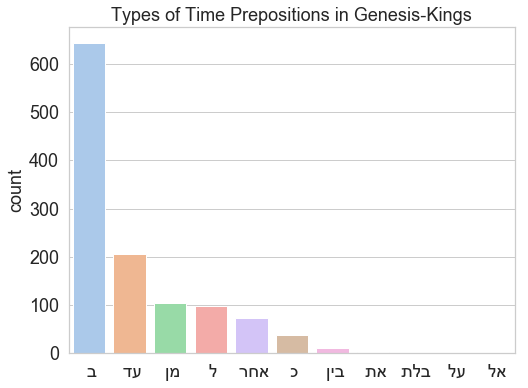



Prepositions and their frequency:



,count
ב,644
עד,205
מן,105
ל,99
אחר,74
כ,38
בין,10
את,2
בלת,1
על,1


In [6]:
'''
Count and plot the prepositions. For x-labels
the letter order has to be reversed 
in order to display properly in the plot
'''

prep_phrases = [res[1] for res in times if F.typ.v(res[1]) == 'PP']
prep_counts = collections.Counter(T.text(E.heads.f(pp)[0], fmt='lex-orig-plain') for pp in prep_phrases)
prep_counts = pd.DataFrame.from_dict(prep_counts, orient='index', columns=['count'])
prep_counts = prep_counts.sort_values(ascending=False, by='count')

barplot_counts(prep_counts, 'Types of Time Prepositions in Genesis-Kings', reverse_labels=True)
print('\n\nPrepositions and their frequency:\n')
prep_counts

<hr>

### Excursus: Locative Phrases

Haspelmath's *From Space to Time* (1997) proposes that time phrases share a genetic relationship with locative phrases. The idea is that locative phrases, which indicate location in three dimensional space, are metaphorically related to the two-dimentional time line (Haspelmath 1997: 21-24). Haspelmath finds this pattern across 53 world languages.

Do we see any similarities between time and locative phrases in the corpus?

The ETCBC stores location-indicating phrases under the function of `Loca`. In the query below, we extract those phrases, in addition to their head words and those head words' lexemes.

Number of Location phrases in Gen-Kgs:
  0.87s 1541 results


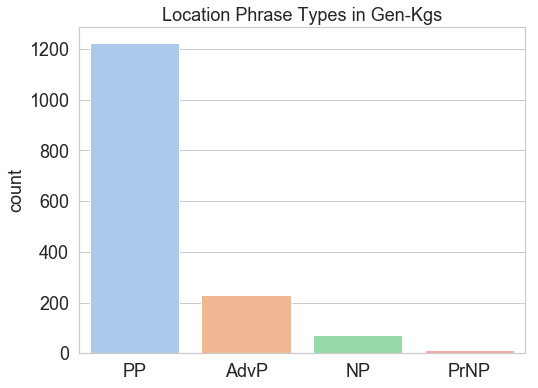

Location Phrase Type Counts in Gen-Kgs:


,count
PP,1225
AdvP,231
NP,73
PrNP,12


In [7]:
loca_phrases = '''
corpus
    p1:phrase function=Loca
        w1:word 
lex
   w2:word
   
p1 -heads> w1
w1 = w2
'''

print('Number of Location phrases in Gen-Kgs:')
locations = B.search(loca_phrases, sets={'corpus': corpus})
loca_counts = count_df(locations, 1, 'typ')
barplot_counts(loca_counts, 'Location Phrase Types in Gen-Kgs')
print('Location Phrase Type Counts in Gen-Kgs:')
loca_counts

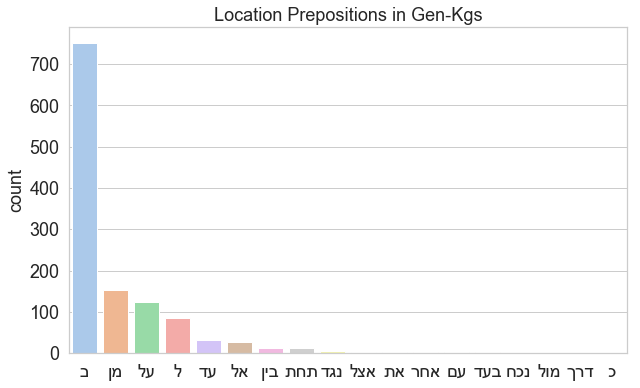

Location Preposition Counts in Gen-Kgs:


,count
ב,752
מן,153
על,123
ל,85
עד,33
אל,27
בין,14
תחת,14
נגד,6
אצל,4


In [8]:
loca_preps = count_df([res for res in locations if F.typ.v(res[1]) == 'PP'], 4, 'lex_utf8')
barplot_counts(loca_preps, 'Location Prepositions in Gen-Kgs', reverse_labels=True, size=(10, 6))
print('Location Preposition Counts in Gen-Kgs:')
loca_preps

We see here that Loca PPs have much more lexical diversity than the Time PPs. 

Below we make further comparisons between the Time and Loca phrases.

In [13]:
# compare location and time phrase types

loca_time = count_types.copy()
loca_time.columns = ['time']
loca_time = pd.concat([loca_time, loca_counts], axis=1, sort=True).fillna(0)
loca_time.columns = ['time', 'loca']
loca_time = loca_time

# normalize the counts
loca_time_norm = loca_time.apply(lambda column: column/column.sum()).sort_values(ascending=False, by='loca')

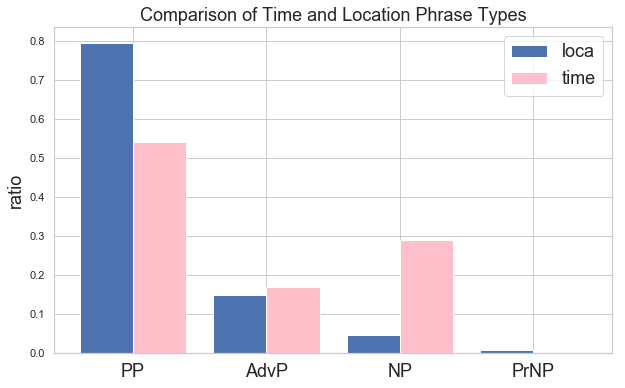


Normalized Ratios of Phrase Types for Time and Loca Function Phrases:


,time,loca
PP,0.541284,0.794938
AdvP,0.168807,0.149903
NP,0.289908,0.047372
PrNP,0.000000,0.007787


In [15]:
# make side-by-side bar charts

width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))   
bar_indices = np.arange(loca_time_norm.shape[0], step=1)
ax.bar(bar_indices, loca_time_norm['loca'], width, label='loca')
ax.bar(bar_indices+width, loca_time_norm['time'], width, label='time', color='pink')
ax.legend(fontsize=18)
ax.set_xticks(bar_indices+width/2)
ax.set_xticklabels(loca_time_norm.index, fontsize=18)
ax.set_ylabel('ratio', fontsize=18)
ax.set_title('Comparison of Time and Location Phrase Types', fontsize=18)
plt.show()
print('\nNormalized Ratios of Phrase Types for Time and Loca Function Phrases:')
loca_time_norm

In [18]:
print('Raw Counts of Phrase Types for Time and Loca Function Phrases:')
loca_time

Raw Counts of Phrase Types for Time and Loca Function Phrases:


,time,loca
AdvP,368.0,231
NP,632.0,73
PP,1180.0,1225
PrNP,0.0,12


#### Testing for Association Strengths

We have observed that there are higher levels of NP in `Time` function phrases than in `Loca` phrases. We have also seen a decrease in the ration of `NP` phrases used with `Time`. Are these differences statistically significant?

In [55]:
#loca_time_fish = pd.DataFrame(...) # TODO

for funct_i in loca_time.columns:
    total_i = loca_time[funct_i].sum()
    
    for typ_j in loca_time.index:
        total_j = loca_time.loc[typ_j].sum()
        
        # get values for fisher's exact test
        a = loca_time[funct_i][typ_j] # observed freq
        b = total_i - a
        c = total_j - a
        d = loca_time.sum().sum() - (a+b+c)
    
        contingency = np.matrix([[a, b], [c, d]])
    
        oddsratio, p_value = stats.fisher_exact(contingency)
        
        #loca_time_fish[funct_i][typ_j] = p_value
        
        print(f'{funct_i} x {typ_j}    =    {p_value}') # put these in DF tomorrow

time x AdvP    =    0.1239307569146235
time x NP    =    1.533068122790432e-88
time x PP    =    3.3520392267159472e-59
time x PrNP    =    2.4818740649469773e-05
loca x AdvP    =    0.1239307569146235
loca x NP    =    1.533068122790432e-88
loca x PP    =    3.352039226715947e-59
loca x PrNP    =    2.4818740649469773e-05


<hr>

Note the high degree of difference between the `Time` and `Loca` noun phrases (`NP`):

In [11]:
loca_time['time']['NP'] - loca_time['loca']['NP']

0.24253642041090917

There is also a slight decrease in `Time`'s preference of a prepositional phrase (`PP`):

In [12]:
loca_time['time']['PP'] - loca_time['loca']['PP']

-0.2536539480499378

Both `Loca` and `Time` are found often as prepositional phrases (`PP`). But `Time` is found as a simple noun phrase (`NP`) much more often (+0.24). This results in a lower ratio of prepositional phrases for `Time` (-0.25). Thus, the bare noun phrase appears to play a more important role in the `Time` function.

Surprisingly, `Time` and `Loca` share a fairly equal preference for the adverb phrase (`AdvP`) at 0.17 and 0.15, respectively. It is not surprising, on the other hand, that `Time` does not appear in a proper noun phrase `PrNP`, since time units do not generally have proper names (with the exception of something like seasons or festivals). 

**TODO: prepare some functions to test for statistical significance levels on the time phrase associations. This is especially necessary to see whether the higher level of `NP` for `Time` over against `Loca` is indeed significant.**